In [3]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, kruskal, shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import scipy.stats as ss


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


### Приложение знакомств
Механика приложения для онлайн-знакомств следующая: пользователи видят в приложении анкеты друг друга и могут ставить друг другу лайки или дизлайки. Если пользователи поставили друг другу лайк – это называется мэтч, и у пользователей появляется возможность познакомиться.

Команда приложения разработала новый алгоритм для поиска наиболее подходящих анкет. Для проверки работы алгоритма был проведен АБ-тест. Все пользователи были разделены на две группы. Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

Моя задача – оценить, правда ли, что новый алгоритм улучшил качество сервиса. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

В данных находится выгрузка логов взаимодействия пользователей друг с другом. Для каждой пары пользователей указано, из какой они группы АБ-теста и случился ли у них мэтч.

Результат моей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему поиска анкет на всех пользователей.

In [4]:
# выгружаем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-shishkova/Files.csv/dating_data.csv')
df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


    Подготовка данных

In [5]:
df.shape

(14514, 4)

In [6]:
# смотрим информацию о данных
df.describe()

,user_id_1,user_id_2,group,is_match
count,14514.000000,14514.000000,14514.000000,14514.000000
mean,500.220132,501.843737,0.669836,0.333678
std,288.703825,287.250879,0.470288,0.471542
min,1.000000,1.000000,0.000000,0.000000
25%,253.000000,255.000000,0.000000,0.000000
50%,504.000000,500.000000,1.000000,0.000000
75%,751.000000,752.750000,1.000000,1.000000
max,1000.000000,1000.000000,1.000000,1.000000


In [7]:
# смотрим информацию о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [8]:
# проверяем пропущенные данные
df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [9]:
# проверяем уникальность 
df.nunique()

user_id_1    1000
user_id_2    1000
group           2
is_match        2
dtype: int64

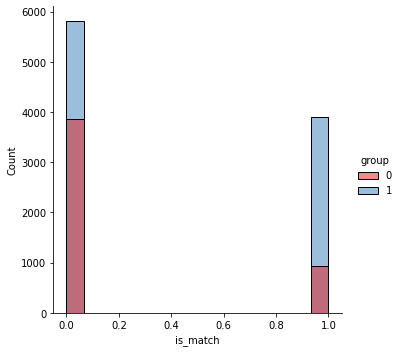

In [10]:
# визуализируем данные по группам
sns.displot(df, x='is_match', hue= 'group', palette="Set1")

    У нас есть две группы: 
        - группа_0 - приложение для пользователей со старым алгоритмом поиска партнера 
        - группа_1 - приложение для пользователей с новым алгоритмом поиска партнера

    На первый взгляд по визуализации мы можем сделать очевидный вывод, что данные нового алгоритма 
    (группа_1) значительно выше.

    Возьмем значения по группам match-событий == 1 как положительный исход и их долю примем за конверсию 
    идеального алгоритма, т.е. оценим результаты поиска партнера по группам.

In [11]:
# пользователи группы 0 со старым алгоритмом приложения 
group_0 = df.query('group == 0')
# пользователи в группе 1 пользовались приложением с новым алгоритмом 
group_1 = df.query('group == 1')

print('Размер выборки группы_0:', group_0.is_match.count()) 
print('Размер выборки группы_1:', group_1.is_match.count()) 
print('Среднее группы_0:', group_0.is_match.mean()) 
print('Среднее группы_1:', group_1.is_match.mean()) 
print('Дисперсия группы_0:', group_0.is_match.var()) 
print('Дисперсия группы_1:', group_1.is_match.var()) 


Размер выборки группы_0: 4792
Размер выборки группы_1: 9722
Среднее группы_0: 0.19490818030050083
Среднее группы_1: 0.40207776177741206
Дисперсия группы_0: 0.15695173441856233
Дисперсия группы_1: 0.24043596638330383


In [12]:
# рассчитаем доверительный интервал группы_0
print('Доверительный интервал группы_0:', ss.t.interval(alpha=0.99, df=len(group_0.is_match)-1, 
                                                        loc=np.mean(group_0.is_match), 
                                                        scale=ss.sem(group_0.is_match)))
# рассчитаем доверительный интервал группы_1
print('Доверительный интервал группы_1:', ss.t.interval(alpha=0.99, df=len(group_1.is_match)-1, 
                                                        loc=np.mean(group_1.is_match), 
                                                        scale=ss.sem(group_1.is_match)))

Доверительный интервал группы_0: (0.18016080315368263, 0.20965555744731904)
Доверительный интервал группы_1: (0.38926554525945894, 0.41488997829536517)


In [13]:
group_0_match = df.query('group == 0 & is_match == 1')
group_1_match = df.query('group == 1 & is_match == 1')
print('Количество мэтчей группы_0:', group_0_match.is_match.count())
print('Количество мэтчей группы_1:', group_1_match.is_match.count())

# процент возможности познакомиться в приложении со старым алгоритмом 
print('Процент возможности познакомиться группы_0:', 
      round(group_0_match.is_match.count() / group_0.is_match.count() * 100, 2))
# процент возможности познакомиться в приложении с новым алгоритмом
print('Процент возможности познакомиться группы_1:', 
      round(group_1_match.is_match.count() / group_1.is_match.count() * 100, 2))

Количество мэтчей группы_0: 934
Количество мэтчей группы_1: 3909
Процент возможности познакомиться группы_0: 19.49
Процент возможности познакомиться группы_1: 40.21


    Мы наблюдаем, что 

        - Размер выборки группы_1 практически в 2 раза больше, чем размер группы_0
        - Среднее значение группы_1 более чем в два раза превышает среднее группы_0
        - Доверительные интервалы выборок с уровнем достоверности 99% не пересекаются
        - В процентном соотношении положительный matсh исход группы_1 в 2 раза выше группы_0


In [14]:
# тестируем нормальность с помощью scipy.stats
print('группа_0:', ss.normaltest(group_0.is_match))
print('группа_1:', ss.normaltest(group_1.is_match))

группа_0: NormaltestResult(statistic=1056.7389057083074, pvalue=3.4045696177523702e-230)
группа_1: NormaltestResult(statistic=37375.72668370961, pvalue=0.0)


In [15]:
# тестируем нормальность с помощью pingouin
pg.normality(data = df, dv='is_match', group='group', method='normaltest')

,W,pval,normal
1,37375.726684,0.000000e+00,False
0,1056.738906,3.404570e-230,False


    Для анализа преобразуем исходные данные в таблицу сопряженности, содержащую номера групп и результатов 
    is_match с разбивкой по количеству удачных и неудачных поисков партнеров.

    В нашем случае is_match принимает всего два значения, то есть является категориальной переменной.

    Для A/B тестирования будем использовать критерий согласия Пирсона(Хи-квадрат).

    Сформулируем гипотезы, которые будем тестировать:

        - Hулевая гипотеза - конверсия match-событий не зависит от группы тестирования 
        - Альтернативная гипотеза - конверсия match-событий зависит от группы тестирования


In [16]:
df_chi = df.groupby(['group','is_match'], as_index = False) \
                                .agg({'user_id_1':'count'}) \
                                .rename(columns={'user_id_1': 'count_users'}) \
                                .pivot_table(index='group', columns='is_match', values='count_users') \
                                .reset_index()[[0,1]].to_numpy()
df_chi

array([[3858,  934],
       [5813, 3909]])

In [17]:
# проводим тест Хи-квадрат
statistic, pvalue, dof, expected = chi2_contingency(df_chi)
print('Statistic:', statistic)
print('Pvalue:', pvalue)
print('Degree of freedom:', dof)

# Проверяем гипотезу о независимости переменных
alpha = 0.05
if pvalue > alpha:
    print("Hулевая гипотеза - конверсия match-событий не зависит от группы тестирования")
else:
    print("Отвергаем нулевую гипотезу. Конверсия match-событий зависит от группы тестирования")

Statistic: 618.6889141576198
Pvalue: 1.4418299163662586e-136
Degree of freedom: 1
Отвергаем нулевую гипотезу. Конверсия match-событий зависит от группы тестирования



    По результатам проведенного теста мы можем сделать вывод: Конверсия зависит от групп тестирования.
    
    Воспользуемся регрессионным анализом, чтобы проверить на сколько сильно влияет новый алгоритм на конверсию 
    для наших данных, возьмем в качестве зависимой переменной is_match, а в качестве независимой - group.

In [18]:
# через statsmodels 
Y = df.is_match # одномерный массив с ЗП
X = df.group # массив с НП

X = sm.add_constant(X)  # добавить константу, чтобы был свободный член
model = sm.OLS(Y, X)  # говорим модели, что у нас ЗП, а что НП
results = model.fit()  # строим регрессионную прямую
print(results.summary())  # смотрим результат

# второй вариант
# results = smf.ols('is_match ~ group', df).fit()
# print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               is_match   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     647.2
Date:                Thu, 11 Jul 2024   Prob (F-statistic):          1.04e-139
Time:                        12:36:36   Log-Likelihood:                -9366.5
No. Observations:               14514   AIC:                         1.874e+04
Df Residuals:                   14512   BIC:                         1.875e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1949      0.007     29.243      0.0

    Вывод: 
        1. По результатам проведенного хи-теста: Конверсия зависит от групп тестирования.
        2. Исходя из результатов регрессионного анализа мы видим, что в среднем при применении нового алгоритма вероятность положительного match-исхода увеличивается приблизительно на 21%, то есть вырастает вдвое. 
    
    Соответственно безусловно стоит включать новый алгоритм поиска анкет на всех пользователей.